In [1]:
import torch
import torch.nn as nn

In [12]:
from PIL import Image
import requests

# from transformers import CLIPProcessor, CLIPModel

# model = CLIPModel.from_pretrained("./CLIP-VIT")
# processor = CLIPProcessor.from_pretrained("./CLIP-VIT")


# Load model directly
from transformers import AutoProcessor, AutoModel

processor = AutoProcessor.from_pretrained("SigLip")
model = AutoModel.from_pretrained("SigLip")

Some weights of the model checkpoint at SigLip were not used when initializing SiglipModel: ['bias', 'temperature', 'text_model.text_model.embeddings.position_embedding.weight', 'text_model.text_model.embeddings.token_embedding.weight', 'text_model.text_model.encoder.layers.0.layer_norm1.bias', 'text_model.text_model.encoder.layers.0.layer_norm1.weight', 'text_model.text_model.encoder.layers.0.layer_norm2.bias', 'text_model.text_model.encoder.layers.0.layer_norm2.weight', 'text_model.text_model.encoder.layers.0.mlp.fc1.bias', 'text_model.text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.text_model.encoder.layers.0.self_attn.k_proj.weight', 'text_model.text_model.encoder.layers.0.self_attn.out_proj.bias', 'text_model.text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.text_model.encoder.laye

In [3]:
model = model.to('cuda')
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# inputs = processor(text=["a photo of a cat", "a photo of two cats"], images=image, return_tensors="pt", padding=True)
# outputs = model(**inputs)
# logits_per_image = outputs.logits_per_image # this is the image-text similarity score
# probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
# probs

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os


In [5]:
def extract_features_clip(image):
    with torch.no_grad():
        inputs = processor.image_processor(images=image, return_tensors="pt").to('cuda')
        image_features = model.get_image_features(**inputs)
        return image_features

In [6]:
def image_search(query):
    with torch.no_grad():
        text_emb = model.get_text_features(**processor.tokenizer(query, return_tensors='pt').to('cuda'))
    
    idx = np.argmax(cosine_similarity(text_emb.cpu(), torch.stack(img_embeddings, dim=0).cpu().squeeze(1)), axis=1)[0]
    result_img = os.listdir('Image-Folder/')[idx]
    
    image_path = os.path.join('Image-Folder', result_img)
    result_image = Image.open(image_path)
    
    return result_image.resize((300,300))

In [1]:
import chromadb

C:\Users\omalv\.conda\envs\acehacks\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


In [8]:
client = chromadb.PersistentClient(path="img_db")
collection =  client.create_collection(
    name="images",
    metadata={"hnsw:space": "cosine"}
)

In [9]:
def create_db(folder):
    img_embeddings = []
    filenames = []
    for image in os.listdir(folder):
        filename = os.path.join(folder,image)
        img = Image.open(filename)
        img_embeddings.append(extract_features_clip(img).cpu().squeeze(0).numpy().tolist())
        filenames.append(filename)
    
    collection.add(
        embeddings = img_embeddings, # embeddings are used to search through the documents
                                          # we pass in the previously calculated embeddings
        documents=filenames, # we send in the titles as the documents
        ids=[str(i) for i in range(len(filenames))], # must be unique for each doc
    )

In [10]:
create_db('Image-Folder/')

In [11]:
def search(query):
    with torch.no_grad():
        text_emb = model.get_text_features(**processor.tokenizer(query, return_tensors='pt').to('cuda'))
    results = collection.query(
        query_embeddings=text_emb.cpu().squeeze(0).tolist(),
        n_results=5, # top n results
    )
    return Image.open(results['documents'][0][0])

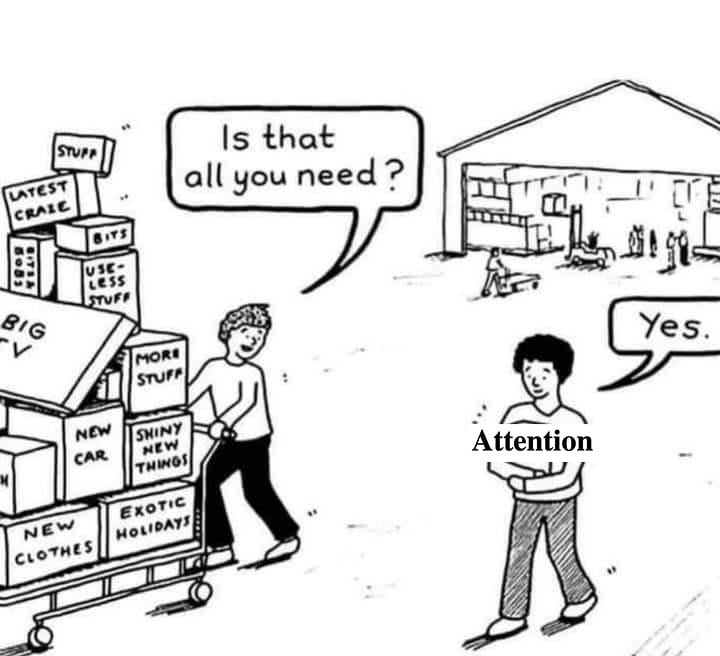

In [29]:
search('a meme about attention')

In [33]:
client.delete_collection("images")

In [1]:
import gradio as gr

C:\Users\omalv\.conda\envs\acehacks\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
interface = gr.Interface(
    fn=search,
    inputs=gr.Textbox(lines=1, placeholder="Enter your text query..."),
    outputs=gr.Image(type="pil"),
    title="Local Image Search Engine",
    description="Search for images in your local folder using text queries.",
)

interface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [2]:
client = chromadb.PersistentClient(path="img_db")

In [4]:
collection = client.get_collection('images')

In [9]:
collection.get()['documents']

['Image-Folder/1_ag6qUFmmXAr4E410Ll-eSQ.png',
 'Image-Folder/1_ZCFSvkKtppgew3cc7BIaug.png',
 'Image-Folder/maine coon.jpg',
 'Image-Folder/metal.jpg',
 'Image-Folder/pfp.jpg',
 'Image-Folder/poster.jpg',
 'Image-Folder/sahil.jpg',
 'Image-Folder/Screenshot 2023-08-22 224546.png',
 'Image-Folder/Screenshot 2023-10-10 223056.png',
 'Image-Folder/Screenshot 2024-04-03 181041.png',
 'Image-Folder/2939b336-1d61-4b01-b977-84ada7f4a332.jpg',
 'Image-Folder/2967bf73-d6e5-4544-82d0-94357c63d617.jpg',
 'Image-Folder/Attention_is_all_you_need.jpg',
 'Image-Folder/british shorthair.jpg',
 'Image-Folder/cert.jpg',
 'Image-Folder/e4420dc2-31a8-4fb3-87a0-789df9c0c5be.jpg',
 'Image-Folder/f549a931-1b45-4720-b32c-a60fd1fa5637.jpg',
 'Image-Folder/ff18d7ba-68dd-4b90-b94a-2ed264bb6053.jpg']

In [3]:
model

SiglipModel(
  (text_model): SiglipTextTransformer(
    (embeddings): SiglipTextEmbeddings(
      (token_embedding): Embedding(32000, 768)
      (position_embedding): Embedding(64, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), 

In [13]:
model.text_model(**processor("Hello world",return_tensors='pt'))

BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 2.0835,  1.1703,  1.0420,  ..., -0.6413,  0.5754, -0.6122],
         [ 2.1130,  1.3014,  0.8679,  ..., -0.6239,  0.7175, -0.6012],
         [ 2.5284,  0.8920,  0.8439,  ..., -0.6132,  0.6627, -0.8655]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 1.0063e+00,  1.3682e+00,  9.1338e-01,  7.0416e-01,  5.0042e-01,
         -7.5089e-01,  6.1454e-01, -1.1232e+00,  1.0960e-01,  8.4337e-01,
          1.1476e+00,  5.8346e-01, -1.6034e+00, -7.2871e-01, -1.0219e+00,
          1.2071e+00,  4.9547e-01,  3.3468e-01, -9.2593e-01, -9.6036e-01,
         -1.0205e+00, -7.0341e-01,  1.1626e+00,  1.2313e+00,  1.1084e+00,
          8.1134e-01, -1.3801e-01,  1.0618e+00, -2.1324e-01,  2.6563e-01,
         -5.8337e-01, -1.5448e-01,  1.0398e+00, -3.1213e-01, -9.7124e-01,
         -6.3427e-01,  3.4181e-01, -3.4053e-01,  1.0917e+00, -8.2030e-01,
         -1.1204e+00,  1.2242e-01,  1.9626e-01,  2.6006e-01, -2.4886e+00,
         -3.5131

In [16]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

texts = ["a photo of 2 cats", "a photo of 2 dogs"]
inputs = processor(text=texts, images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image) # these are the probabilities
print(f"{probs[0][0]:.1%} that image 0 is '{texts[0]}'")

50.5% that image 0 is 'a photo of 2 cats'


{'input_ids': tensor([[ 262,  266, 1304,  267,  454, 6473,    1],
        [ 262,  266, 1304,  267,  454, 3014,    1]]), 'pixel_values': tensor([[[[ 0.1137,  0.1686,  0.1922,  ..., -0.1922, -0.1843, -0.1922],
          [ 0.1373,  0.1686,  0.1843,  ..., -0.1922, -0.1922, -0.2078],
          [ 0.1137,  0.1529,  0.1608,  ..., -0.2392, -0.2235, -0.2078],
          ...,
          [ 0.8431,  0.7882,  0.7255,  ...,  0.7098,  0.6549,  0.6314],
          [ 0.8275,  0.7961,  0.7725,  ...,  0.6157,  0.4902,  0.4196],
          [ 0.8275,  0.7569,  0.7647,  ...,  0.0275, -0.1059, -0.2471]],

         [[-0.8118, -0.8118, -0.8118,  ..., -0.8902, -0.8902, -0.8980],
          [-0.7882, -0.7882, -0.7882,  ..., -0.8824, -0.8745, -0.8824],
          [-0.8196, -0.8039, -0.7882,  ..., -0.8980, -0.8902, -0.8902],
          ...,
          [-0.2627, -0.3255, -0.3725,  ..., -0.4196, -0.4510, -0.4745],
          [-0.2627, -0.2863, -0.3412,  ..., -0.4667, -0.5373, -0.5686],
          [-0.2784, -0.3412, -0.3490,  .

In [17]:
import pickle

In [1]:
import numpy as np
import gradio as gr


def flip_text(x):
    return x[::-1]


def flip_image(x):
    return np.fliplr(x)


with gr.Blocks() as demo:
    gr.Markdown("Flip text or image files using this demo.")
    with gr.Tab("Flip Text"):
        text_input = gr.Textbox()
        text_output = gr.Textbox()
        text_button = gr.Button("Flip")
    with gr.Tab("Flip Image"):
        with gr.Row():
            image_input = gr.Image()
            image_output = gr.Image()
        image_button = gr.Button("Flip")

    with gr.Accordion("Open for More!", open=False):
        gr.Markdown("Look at me...")
        temp_slider = gr.Slider(minimum=0.0, maximum=1.0, value=0.1, step=0.1, interactive=True, label="Slide me")
        temp_slider.change(lambda x:x, [temp_slider])

    text_button.click(flip_text, inputs=text_input, outputs=text_output)
    image_button.click(flip_image, inputs=image_input, outputs=image_output)

demo.launch(debug=True)


C:\Users\omalv\.conda\envs\acehacks\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


KeyboardInterrupt: 

In [1]:
import gradio as gr
import chromadb
import torch
import torch.nn as nn

from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import os

print("Loading model...")

model = CLIPModel.from_pretrained("./CLIP-VIT").to('cuda')
processor = CLIPProcessor.from_pretrained("./CLIP-VIT")

print("Model loaded!")

client = chromadb.PersistentClient('img_db/')

def search(query):
    collection = client.get_collection('images')
    with torch.no_grad():
        text_emb = model.get_text_features(**processor.tokenizer(query, return_tensors='pt').to('cuda'))
    results = collection.query(
        query_embeddings=text_emb.cpu().squeeze(0).tolist(),
        n_results=5, # top n results
    )
    return Image.open(results['documents'][0][0])



C:\Users\omalv\.conda\envs\acehacks\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\omalv\.conda\envs\acehacks\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


Loading model...
Model loaded!


In [29]:
import gradio as gr

css = """
.image-container {
    display: flex;
    justify-content: center;
    align-items: center;
}

.image-container img {
    max-width: 100%;
    max-height: 500px;
    object-fit: contain;
}

.custom-button {
    background-color: #9b59b6 !important; /* Purple color */
    color: white !important;
    padding: 0.5rem 1rem !important;
    border: none !important;
    border-radius: 4px !important;
    cursor: pointer !important;
    font-size: 1rem !important;
}

.custom-button:hover {
    background-color: #8e44ad !important; /* Darker purple on hover */
}
"""


with gr.Blocks(css=css) as demo:
    gr.Markdown("# Where's My Picture? : A Local Image Search Engine")
    gr.Markdown("Search for images in your local folder using text queries.")

    with gr.Row(elem_classes="search-row"):
        text_input = gr.Textbox(lines=1, placeholder="Enter your text query...", scale=3)
        search_button = gr.Button("Search", elem_classes="custom-button", scale=1)

    with gr.Row(elem_classes="image-container"):
        image_output = gr.Image(type="pil", height=500, width=500)

    text_input.submit(
        fn=search,
        inputs=text_input,
        outputs=image_output
    )

    search_button.click(
        fn=search,
        inputs=text_input,
        outputs=image_output
    )

demo.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


KeyboardInterrupt: 

In [23]:
interface = gr.Interface(
    fn=search,
    inputs=gr.Textbox(lines=1, placeholder="Enter your text query..."),
    outputs=gr.Image(type="pil"),
    title="Where's My Picture? : A Local Image Search Engine",
    description="Search for images in your local folder using text queries.",
    theme=gr.themes.Default(primary_hue=gr.themes.colors.purple, secondary_hue=gr.themes.colors.pink)
)

interface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


KeyboardInterrupt: 

In [3]:
import gradio as gr
import chromadb
import torch
import torch.nn as nn
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import os

print("Loading model...")
model = CLIPModel.from_pretrained("./CLIP-VIT").to('cuda')
processor = CLIPProcessor.from_pretrained("./CLIP-VIT")
print("Model loaded!")

client = chromadb.PersistentClient('img_db/')

def search(query):
    collection = client.get_collection('images')
    with torch.no_grad():
        text_emb = model.get_text_features(**processor.tokenizer(query, return_tensors='pt').to('cuda'))
    results = collection.query(
        query_embeddings=text_emb.cpu().squeeze(0).tolist(),
        n_results=4  # top n results
    )
    # Create a gallery of the top 5 results
    gallery_images = [Image.open(doc) for doc in results['documents'][0]]
    return gallery_images

demo = gr.Interface(
    fn=search,
    inputs=gr.Textbox(placeholder="Enter a query"),
    outputs=gr.Gallery(label="Results",selected_index=0,preview=True),
    title="Where's My Pic?",
    description="A local image search engine powered by CLIP!",
    theme = gr.themes.Default(primary_hue="purple")
)

demo.launch()

Loading model...
Model loaded!
Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Exception in thread Thread-12 (_do_normal_analytics_request):
Traceback (most recent call last):
  File "C:\Users\omalv\.conda\envs\acehacks\Lib\site-packages\httpx\_transports\default.py", line 69, in map_httpcore_exceptions
    yield
  File "C:\Users\omalv\.conda\envs\acehacks\Lib\site-packages\httpx\_transports\default.py", line 233, in handle_request
    resp = self._pool.handle_request(req)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\omalv\.conda\envs\acehacks\Lib\site-packages\httpcore\_sync\connection_pool.py", line 216, in handle_request
    raise exc from None
  File "C:\Users\omalv\.conda\envs\acehacks\Lib\site-packages\httpcore\_sync\connection_pool.py", line 196, in handle_request
    response = connection.handle_request(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\omalv\.conda\envs\acehacks\Lib\site-packages\httpcore\_sync\connection.py", line 99, in handle_request
    raise exc
  File "C:\Users\omalv\.conda\envs\acehacks\Lib\site-packages\htt